# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to make a recommendation of a **neighborhood/borough** to book an accomodation in for a tourist who is trying to enjoy the best **clubs** in **Berlin**, Germany.

Since there are a lot of nightclubs in Berlin, the aim of this project is to specifically look for the 100 most popular clubs and then recognize which boroughs have the highest concentration of cool locations.


## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* Number existing clubs in the neighborhood  
* distance of neighborhood from city center

We decided to use regularly spaced grid of locations, centered around city center, to define our neighborhoods.

Following data sources will be needed to extract/generate the required information:
* Geospatial codes of every Borough through the this geojson file https://github.com/m-hoerz/berlin-shapes/blob/master/berliner-bezirke.geojson.
* The best 100 clubs and their location will be obtained using **Foursquare API**

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
!conda install -c conda-forge geocoder --yes

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.1
  latest version: 4.9.2

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geocoder


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    brotlipy-0.7.0             |py36he6145b8_1001         347 KB  conda-forge
    ca-certificates-2020.11.8  |       ha878542_0         145 KB  conda-forge
    certifi-2020.11.8          |   py36h5fab9bb_0         150 KB  conda-forge
    chardet-3.0.4              |py36h9880bd3_1008         194 KB  conda-forge
    click-7.1.2                |     pyh9f0ad1d_0          64 KB  conda-forge
    cryptography-3.2.1         |   py36h6ec43e4_0         633 KB  conda-forge
    future-0.18.2              |   py36h5fab9bb_2         

In [1]:
pip install geopy

     |████████████████████████████████| 112kB 6.2MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [45]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


Let's now retrieve the geographical coordinates of the center of Berlin from the **geopy** library.

In [46]:
address = 'Berlin, DE'

geolocator = Nominatim(user_agent="berlin_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
berlin_center=[latitude, longitude]
print('The geographical coordinate of Berlin are {}, {}.'.format(latitude, longitude))

The geographical coordinate of Berlin are 52.5015217, 13.4025498.


Let's now retrieve the geographical coordinates of the different boroughs of Berlin from the the geojson file.

In [47]:
berlin_boroughs_url = 'https://raw.githubusercontent.com/m-hoerz/berlin-shapes/master/berliner-bezirke.geojson'
berlin_boroughs = requests.get(berlin_boroughs_url).json()

def boroughs_style(feature):
    return { 'color': 'blue', 'fill': False }

In [48]:
boroughs = berlin_boroughs['features']


In [49]:
dfboroughs= json_normalize(boroughs)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """Entry point for launching an IPython kernel.


Let's now visualize Berlin's neighborhoods.

In [50]:
map_berlin = folium.Map(location=berlin_center, zoom_start=10)
folium.GeoJson(berlin_boroughs, style_function=boroughs_style, name='geojson').add_to(map_berlin)
folium.TileLayer('cartodbpositron').add_to(map_berlin) #cartodbpositron cartodbdark_matter
map_berlin

### Foursquare
Now that we have our borough candidates, let's use Foursquare API to get info on clubs in each area.
We're interested in venues in the 'nightclub' category. So that the tourist stays in a relatively central area, we are going to limit our search to 5km to city center. Those will be measured from the city center retrieved from the geopy library.

In [51]:
CLIENT_ID = 'LJRGG3GET4PVYI5TATI4IDVIS0KVC34MCGVR0VRTNNFUOPRZ' # your Foursquare ID
CLIENT_SECRET = 'FELO3EBJK3LTL5LGZ2B0G3R225FFMNWPJ31FIY351SCF5Y41' # your Foursquare Secret
VERSION = '20201155' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [52]:
LIMIT =100 # limit of number of venues returned by Foursquare API

radius = 5000 # define radius
categoryId= '4bf58dd8d48988d11f941735'
 # create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT,
    categoryId)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=LJRGG3GET4PVYI5TATI4IDVIS0KVC34MCGVR0VRTNNFUOPRZ&client_secret=FELO3EBJK3LTL5LGZ2B0G3R225FFMNWPJ31FIY351SCF5Y41&v=20201155&ll=52.5015217,13.4025498&radius=5000&limit=100&categoryId=4bf58dd8d48988d11f941735'

In [53]:
results = requests.get(url).json()



In [54]:
results

{'meta': {'code': 200, 'requestId': '5fb69beb71cf8433225962db'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Berlin',
  'headerFullLocation': 'Berlin',
  'headerLocationGranularity': 'city',
  'query': 'nightclub',
  'totalResults': 105,
  'suggestedBounds': {'ne': {'lat': 52.54652174500004,
    'lng': 13.476334992896282},
   'sw': {'lat': 52.45652165499995, 'lng': 13.328764607103716}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5390e7a5498e1eb4652bffe4',
       'name': 'Kater Blau',
       'location': {'address': 'Holzmarktstr. 25',
        'lat': 52.51186304262993,
        'lng': 13.425768449360852,
        'labeledLatLngs': [{'label': 'display',
          'lat': 52.5118

## Methodology <a name="methodology"></a>

Now let's create a pandas dataframe to group the venues retireved from Foursquare.

In [55]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [56]:


venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Kater Blau,Nightclub,52.511863,13.425768
1,Golden Gate,Nightclub,52.516030,13.416619
2,Walzerlinksgestrickt,Nightclub,52.487900,13.387940
3,Ritter Butzke,Nightclub,52.502823,13.408046
4,Berghain,Nightclub,52.511396,13.443199


In [57]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


Looking good. Now let's try for visualization's sake plot the geospatial coordinates of the retrieved clubs on the Berlin map.

In [58]:

map_berlin = folium.Map(location=berlin_center, zoom_start=10)
folium.GeoJson(berlin_boroughs, style_function=boroughs_style, name='geojson').add_to(map_berlin)
folium.TileLayer('cartodbpositron').add_to(map_berlin)   
for lat, lng, label in zip(nearby_venues['lat'], nearby_venues['lng'], nearby_venues['name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_berlin)  
map_berlin

Now the goal is to assign every club to a borough. In order to do so we are going to use the shapely library and the "polygon" function to see if the geospatial coordinates of every club belongs to any of the saved geospatial areas of the boroughs

In [21]:
pip install shapely

     |████████████████████████████████| 1.0MB 8.6MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [59]:
from shapely.geometry import Point, Polygon

In [60]:
poly=list()
for bor in range(dfboroughs.shape[0]):

    for x in range(len(dfboroughs['geometry.coordinates'][bor][0])):
        dfboroughs['geometry.coordinates'][bor][0][x] = tuple(dfboroughs['geometry.coordinates'][bor][0][x])
    
    poly.append(Polygon(dfboroughs['geometry.coordinates'][bor][0]))
        

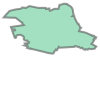

In [61]:
poly[0]

In [62]:
venue_borough= list()
for ven in range(nearby_venues.shape[0]):
    for bor in range(dfboroughs.shape[0]): 
        if Point(nearby_venues.iloc[ven]['lng'],nearby_venues.iloc[ven]['lat']).within(poly[bor]):
            
            venue_borough.append(dfboroughs['properties.spatial_alias'][bor])
          
            

In [63]:
venue_borough= pd.DataFrame(venue_borough)

In [64]:
nearby_venues['borough']= venue_borough

In [65]:
nearby_venues.head()

,name,categories,lat,lng,borough
0,Kater Blau,Nightclub,52.511863,13.425768,Friedrichshain-Kreuzberg
1,Golden Gate,Nightclub,52.516030,13.416619,Mitte
2,Walzerlinksgestrickt,Nightclub,52.487900,13.387940,Friedrichshain-Kreuzberg
3,Ritter Butzke,Nightclub,52.502823,13.408046,Friedrichshain-Kreuzberg
4,Berghain,Nightclub,52.511396,13.443199,Friedrichshain-Kreuzberg


Looks good. Now let's group the clubs by borough.

In [66]:
nearby_venues.groupby('borough').count()

,name,categories,lat,lng
borough,,,,
Charlottenburg-Wilmersdorf,5,5,5,5
Friedrichshain-Kreuzberg,52,52,52,52
Lichtenberg,4,4,4,4
Mitte,24,24,24,24
Neukölln,3,3,3,3
Pankow,5,5,5,5
Tempelhof-Schöneberg,4,4,4,4
Treptow-Köpenick,3,3,3,3


Looks like **Friedrichshain-Kreuzberg** is by far the borough in Berlin with the most clubs.

In the next step we are going to apply the k-means clustering method to find clusters of clubs and check if their centroids belong to this borough.

In [67]:
colors_map = np.array(['b', 'r'])
def assign_members(x1, x2, centers):
    compare_to_first_center = np.sqrt(np.square(np.array(x1) - centers[0][0]) + np.square(np.array(x2) - centers[0][1]))
    compare_to_second_center = np.sqrt(np.square(np.array(x1) - centers[1][0]) + np.square(np.array(x2) - centers[1][1]))
    class_of_points = compare_to_first_center > compare_to_second_center
    colors = colors_map[class_of_points + 1 - 1]
    return colors, class_of_points

print('assign_members function defined!')

assign_members function defined!


In [68]:
# update means
def update_centers(x1, x2, class_of_points):
    center1 = [np.mean(np.array(x1)[~class_of_points]), np.mean(np.array(x2)[~class_of_points])]
    center2 = [np.mean(np.array(x1)[class_of_points]), np.mean(np.array(x2)[class_of_points])]
    return [center1, center2]

print('assign_members function defined!')

assign_members function defined!


In [69]:
import matplotlib.pyplot as plt # plotting library
# backend for rendering plots within the browser
%matplotlib inline 

In [70]:
x1= nearby_venues['lat']
x2= nearby_venues['lng']

In [71]:
def plot_points(centroids=None, colors='g', figure_title=None):
    # plot the figure
    fig = plt.figure(figsize=(15, 10))  # create a figure object
    ax = fig.add_subplot(1, 1, 1)
    
    centroid_colors = ['bx', 'rx']
    if centroids:
        for (i, centroid) in enumerate(centroids):
            ax.plot(centroid[0], centroid[1], centroid_colors[i], markeredgewidth=5, markersize=20)
    plt.scatter(x1, x2, s=500, c=colors)
    
    
    
    # add labels to axes
    ax.set_xlabel('x1', fontsize=20)
    ax.set_ylabel('x2', fontsize=20)
    
    # add title to figure
    ax.set_title(figure_title, fontsize=24)

    plt.show()

print('plot_points function defined!')

plot_points function defined!


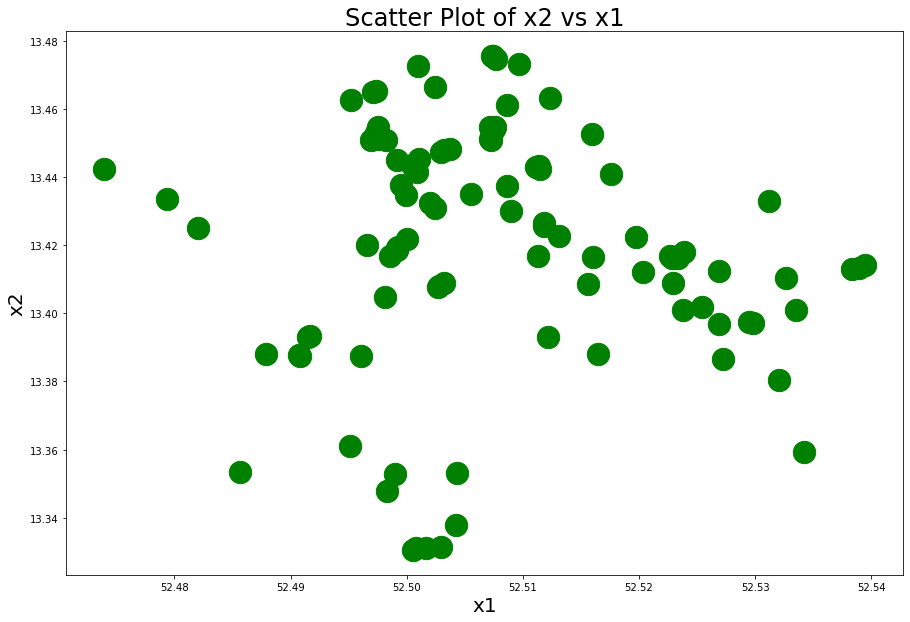

In [72]:
plot_points(figure_title='Scatter Plot of x2 vs x1')

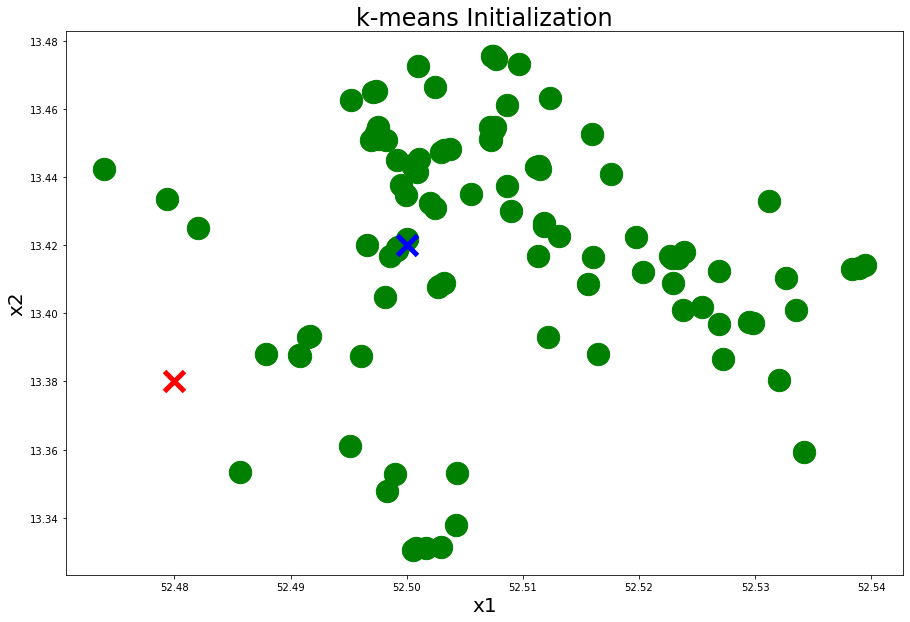

In [73]:
centers = [[52.5, 13.42], [52.48, 13.38]]
plot_points(centers, figure_title='k-means Initialization')

Iteration 1 - Press Enter to update the members of each cluster 


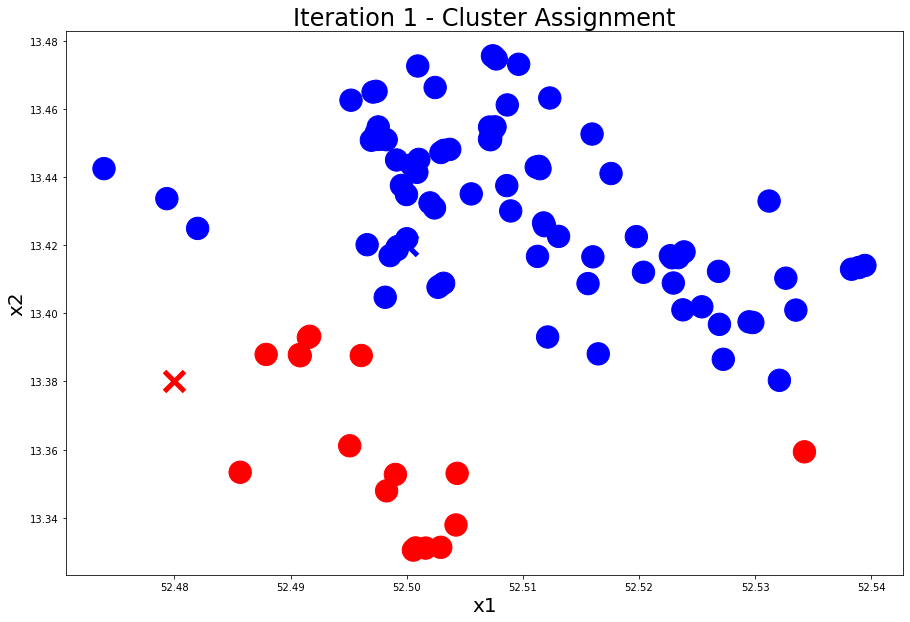

Iteration 1 - Press Enter to update the centers 
Iteration 2 - Press Enter to update the members of each cluster 


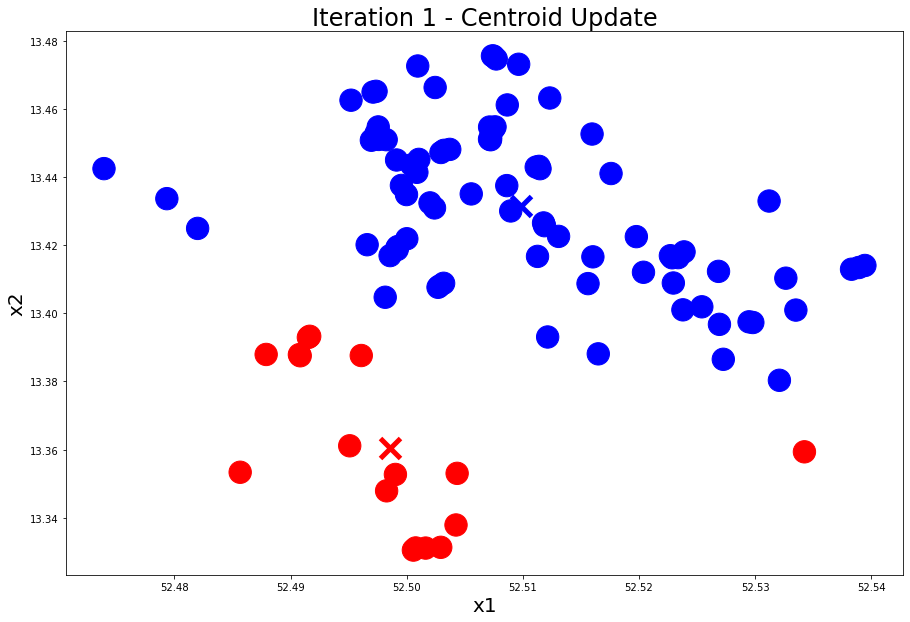

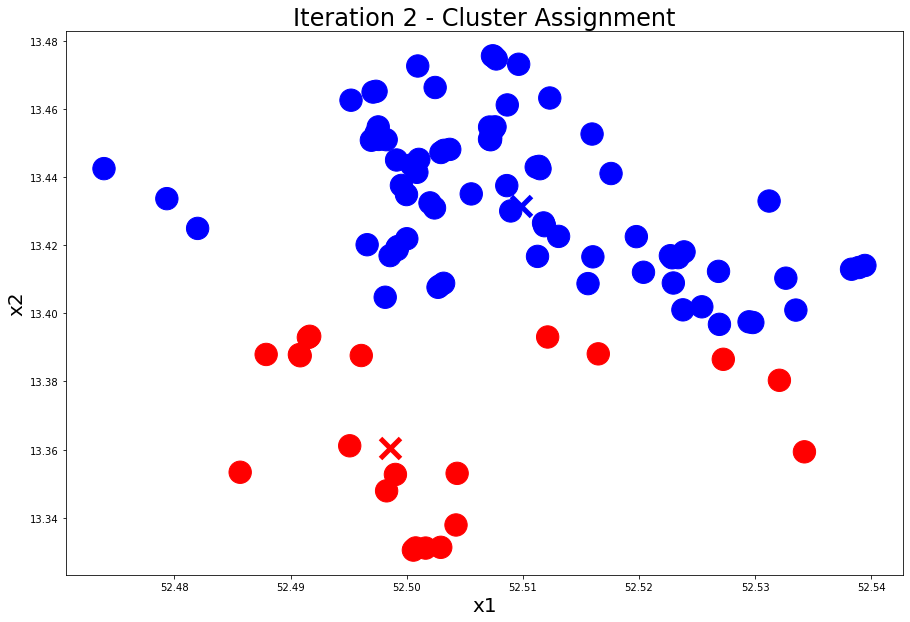

Iteration 2 - Press Enter to update the centers 


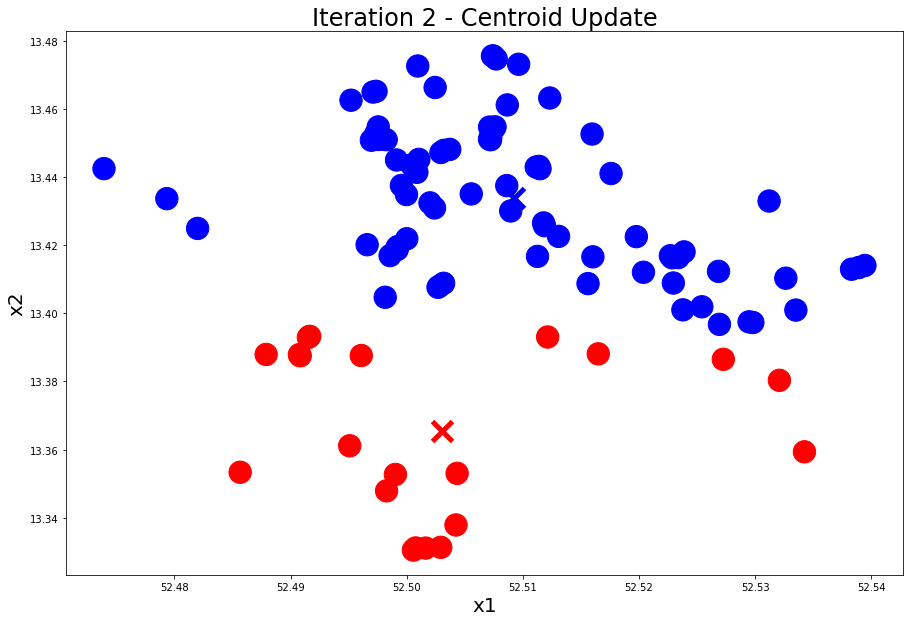

Iteration 3 - Press Enter to update the members of each cluster 


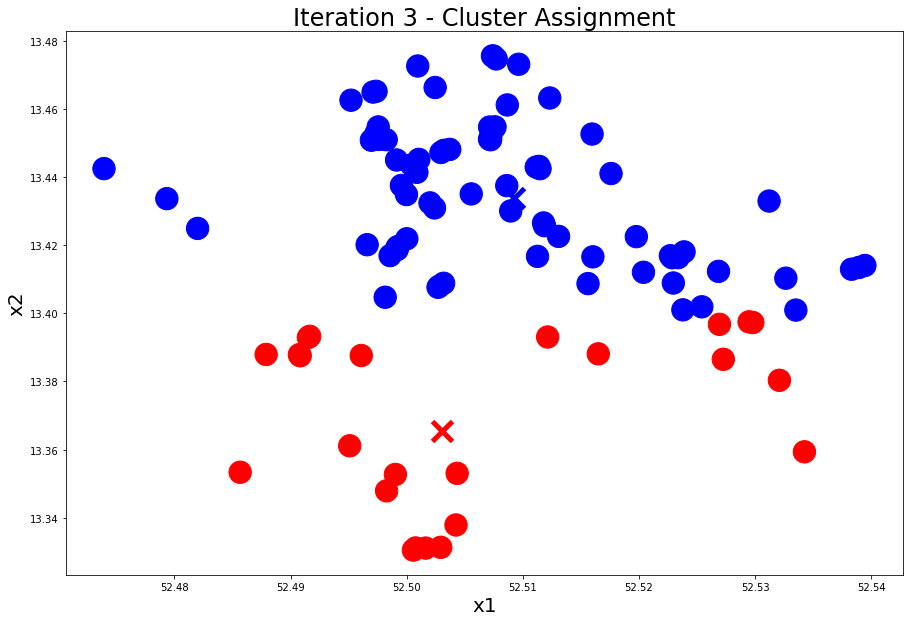

Iteration 3 - Press Enter to update the centers 


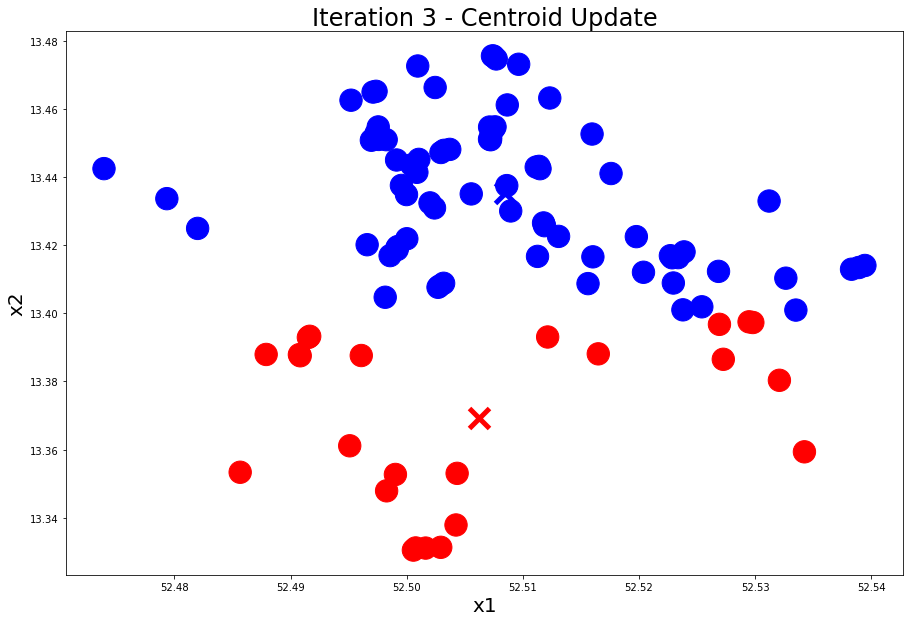

Iteration 4 - Press Enter to update the members of each cluster 


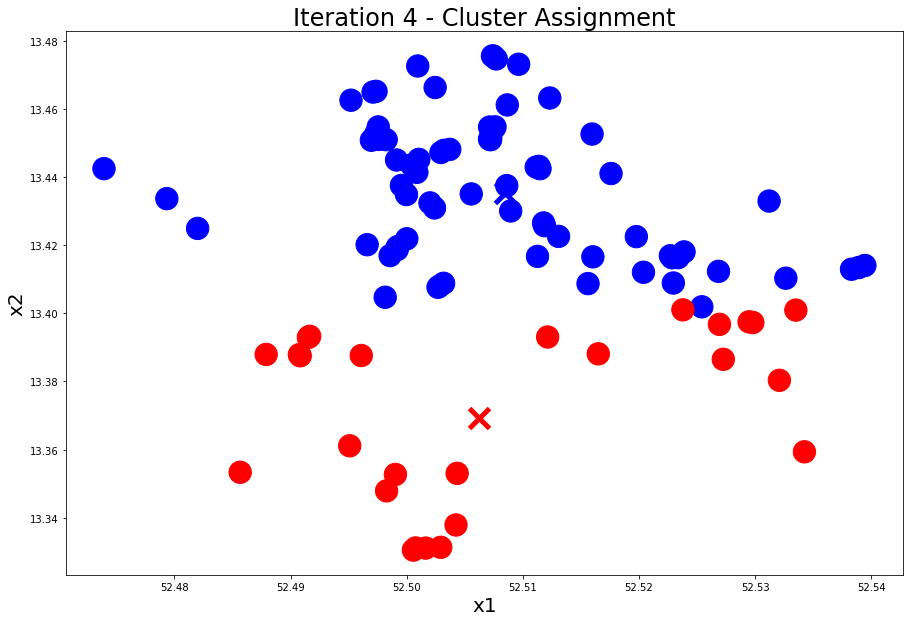

Iteration 4 - Press Enter to update the centers 


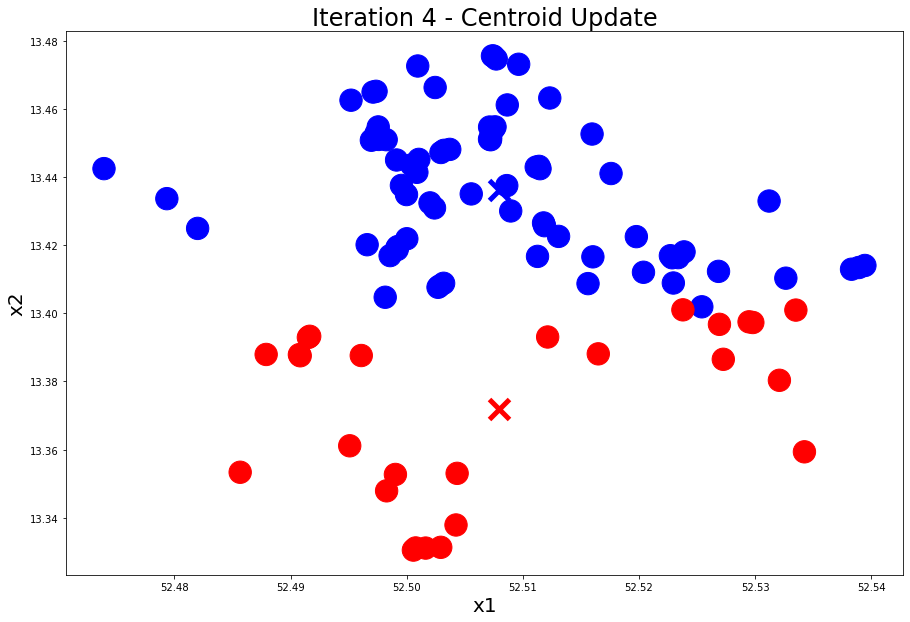

In [74]:
number_of_iterations = 4
for i in range(number_of_iterations):
    input('Iteration {} - Press Enter to update the members of each cluster'.format(i + 1))
    colors, class_of_points = assign_members(x1, x2, centers)
    title = 'Iteration {} - Cluster Assignment'.format(i + 1)
    plot_points(centers, colors, figure_title=title)
    input('Iteration {} - Press Enter to update the centers'.format(i + 1))
    centers = update_centers(x1, x2, class_of_points)
    title = 'Iteration {} - Centroid Update'.format(i + 1)
    plot_points(centers, colors, figure_title=title)

Cool. Now now let's try and find out to which boroughs those two centroids belong. 

**Centroid 1**

In [89]:
for bor in range(dfboroughs.shape[0]): 
        if Point(centers[0][1],centers[0][0]).within(poly[bor]):
            
            print(dfboroughs['properties.spatial_alias'][bor])

Friedrichshain-Kreuzberg


Looks like the first centroid belongs to the borough **Friedrichshain-Kreuzberg**. This validates the primary results found in the last step.

**Centroid 2**

In [90]:
for bor in range(dfboroughs.shape[0]): 
        if Point(centers[1][1],centers[1][0]).within(poly[bor]):
            
            print(dfboroughs['properties.spatial_alias'][bor])

Mitte


The second centroid on the other hand was found in the borough **Mitte**. This was the borough with the second highest number of venues.

## Results and Discussion <a name="results"></a>

We found out that **Friedrichshain-Kreuzberg** has the highest number of nightclubs in Berlin with 54. In the second place was **Mitte** with roughly half as many with 23 nightclubs. After performing a clustering analysis with k_means and 4 iterations we found out that the centroids of two resulting clusters belong to different boroughs, namely one to **Friedrichshain-Kreuzberg** and one to **Mitte**.

## Conclusion <a name="results"></a>

This concludes our analysis. We will recommend both boroughs to book an accommodation, while giving a slight edge to **Friedrichshain-Kreuzberg**, since it had roughly twice as much nightclubs as **Mitte**.